<a href="https://colab.research.google.com/github/parimalakettymuthu/MachineLearning-Projects/blob/main/MultiLabel_Classification_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [501]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [502]:
import sys 
#sys.path.append('/content/drive/MyDrive/NLP/custom-functions')

In [503]:
import pandas as pd
from pathlib import Path
import joblib
# Importing the necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext.vocab import  vocab

import random
import numpy as np
import pandas as pd
import joblib
from collections import Counter


from pathlib import Path
import sys

from sklearn.model_selection import train_test_split
!pip install wandb -qq
import wandb

In [504]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')   
  base_path = '/content/drive/MyDrive/NLP'
  sys.path.append('/content/drive/MyDrive/NLP/user-defined-fns')
  sys.path.append('/content/drive/MyDrive/NLP/user-defined-fn')
  sys.path.append('/content/drive/MyDrive/NLP/user-defined')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [505]:
base_folder = Path(base_path)
assignment_fldr = base_folder/ 'assignment6'
custom_fldr = base_folder/ 'user-defined-fn'

#Check contents in data folder
for entries in custom_fldr.iterdir():
  print(entries.name)

data_preparation_imdb_rev0.py
.ipynb_checkpoints
__pycache__


In [506]:
#sys.path.append('/content/drive/MyDrive/NLP/custom-functions')
sys.path = list(set(sys.path))

In [507]:
sys.path

['',
 '/root/.ipython',
 '/content/drive/MyDrive/NLP/user-defined',
 '/content/drive/MyDrive/NLP/user-defined-fns',
 '/content',
 '/content/drive/MyDrive/NLP/user-defined-fn',
 '/usr/lib/python3.9',
 '/usr/lib/python3.9/lib-dynload',
 '/usr/local/lib/python3.9/dist-packages',
 '/usr/local/lib/python3.9/dist-packages/IPython/extensions',
 '/usr/lib/python39.zip',
 '/usr/lib/python3/dist-packages',
 '/env/python']

In [508]:
!pip install torchmetrics -qq

In [509]:
from Trainer_v2 import Trainer
from ff_3_layer_sequential_model import MLPCustom

In [510]:
from data_preparation_imdb_rev0 import *

In [511]:
df_multilable_data = assignment_fldr/ 'df_multilabel_hw_cleaned.joblib'
multiLabel_Data = joblib.load(df_multilable_data)

In [512]:
multiLabel_Data.columns

Index(['cleaned_text', 'Tags', 'Tag_Number'], dtype='object')

In [513]:
multiLabel_Data.shape

(47427, 3)

In [514]:
print(set(multiLabel_Data['Tag_Number']))

{'[0, 2, 3, 9, 6]', '[0, 2, 5, 9]', '[2, 3, 5, 9]', '[0, 1, 3, 5]', '[8, 6]', '[0, 2, 3, 9, 5]', '[2, 5, 7]', '[0, 1, 2, 3, 4]', '[3, 5, 9]', '[3, 5]', '[0, 3, 9, 5]', '[0, 9, 3]', '[7, 3]', '[0, 6]', '[3, 4, 5, 8]', '[0, 3]', '[1, 2, 3, 6, 7]', '[4, 1]', '[0, 2, 3, 5, 9]', '[2, 9]', '[4, 5]', '[1, 2, 3, 5]', '[2, 4]', '[2, 3]', '[0, 2, 9]', '[0, 8]', '[0, 1, 7]', '[4, 8]', '[1, 2, 9]', '[9, 3, 5]', '[1, 8, 9, 4]', '[1, 2, 5]', '[0, 1, 2, 3, 5]', '[3, 9, 4]', '[2, 5, 3]', '[3, 5, 4]', '[3, 9, 5]', '[2, 3, 6]', '[0, 2, 3, 9]', '[0, 6, 7]', '[1, 4, 9]', '[3, 6]', '[8, 4, 7]', '[0, 8, 4]', '[0, 9, 8]', '[3, 8, 9]', '[9, 3]', '[2, 3, 8]', '[0, 2, 3, 6]', '[2, 3, 7]', '[1, 4, 6]', '[1, 6, 8]', '[0, 8, 9]', '[0, 5, 3]', '[1, 2, 4]', '[0, 9]', '[0, 7]', '[2, 3, 5]', '[3, 5, 8]', '[1, 2, 3, 4]', '[0, 2, 3]', '[0, 1, 2, 9]', '[0, 3, 5]', '[1, 2, 7]', '[3, 7]', '[0, 9, 7]', '[6, 2]', '[0, 4]', '[0, 9, 6]', '[0, 4, 8, 9]', '[0, 4, 9]', '[5, 7]', '[1, 3, 6]', '[1, 6]', '[1, 8]', '[1, 3, 5, 4]', '[

In [515]:
import ast
# assume 'df' is your pandas DataFrame
multiLabel_Data['Tag_Number'] = multiLabel_Data['Tag_Number'].apply(lambda x: [int(i) for i in ast.literal_eval(x)])

In [516]:
from sklearn.preprocessing import MultiLabelBinarizer

# assume 'labels' is your list of labels (i.e., 'Tag_Number' column after conversion to integers)
mlb = MultiLabelBinarizer()
multiLabel_Data['Tag_Number'] = mlb.fit_transform(multiLabel_Data['Tag_Number'])


In [517]:
multiLabel_Data['Tag_Number']

0        1
1        0
2        1
3        0
4        0
        ..
47422    0
47423    0
47424    0
47425    0
47426    0
Name: Tag_Number, Length: 47427, dtype: int64

In [518]:
multiLabel_Data['Tag_Number'].shape


(47427,)

In [519]:
X_final = multiLabel_Data['cleaned_text'].values

In [520]:
print(type(X_final), X_final.shape)

<class 'numpy.ndarray'> (47427,)


In [521]:
y_final = multiLabel_Data['Tag_Number'].values
unique_labels = np.unique(y_final)
print(unique_labels)

[0 1]


In [522]:
print(type(y_final), y_final.shape)

<class 'numpy.ndarray'> (47427,)


#Create Train/Test/Valid Split

In [523]:
X_train, x_valid_test, y_train, y_valid_test = train_test_split(X_final, y_final, test_size = 0.4, stratify = y_final)

In [524]:
X_valid, X_test, y_valid, y_test = train_test_split(x_valid_test, y_valid_test, test_size = 0.5, stratify = y_valid_test)

In [525]:
print("Train set shape: ", X_train.shape, "Split %: ", len(X_train)/len(X_final))
print("Validation set shape: ", X_valid.shape,"Split %: ", len(X_valid)/len(X_final))
print("Test set shape: ", X_test.shape, "Split %: ", len(X_test)/len(X_final))

Train set shape:  (28456,) Split %:  0.59999578299281
Validation set shape:  (9485,) Split %:  0.19999156598562
Test set shape:  (9486,) Split %:  0.20001265102156998


In [526]:
trainset = CustomDataset(X_train,y_train)
validset = CustomDataset(X_valid,y_valid)
testset = CustomDataset(X_test,y_test)

In [527]:
print(set(y_train),set(y_valid),set(y_test))

{0, 1} {0, 1} {0, 1}


#Create vocab

In [528]:
multilabel_vocab = get_vocab(trainset, min_freq=2)

In [529]:
len(multilabel_vocab)

91260

In [530]:
valid_multilabel_vocab = get_vocab(validset, min_freq=2)

#Meta Data

In [531]:
from types import SimpleNamespace

hyperparameters = SimpleNamespace(
    # model Parameters
    EMBED_DIM=300,
    VOCAB_SIZE=len(multilabel_vocab),
    OUTPUT_DIM=10,
    HIDDEN_DIM1=200,
    HIDDEN_DIM2=100,
    NON_LINEARITY=F.relu,
    
    # training 
    EPOCHS=5,
    BATCH_SIZE=128,
    LEARNING_RATE=0.001,
    WEIGHT_DECAY=0.000,
    CLIP_TYPE = 'value',
    CLIP_VALUE = 10,
    PATIENCE=5,
    MOMENTUM=0,  
)

#Trainer Configuration

In [532]:
'''def collate_batch_multilabel(batch, vocab, num_classes):
    labels, texts = zip(*batch)
    labels = torch.tensor(labels, dtype=torch.float32)
    #labels = torch.tensor(labels, dtype=torch.float32).to(torch.float32)
    labels = torch.nn.functional.one_hot(labels.to(torch.int64), num_classes=num_classes)

    list_of_list_of_indices = [text_pipeline(text, vocab) for text in texts]

    offsets = [0] + [len(i) for i in list_of_list_of_indices]
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    texts = torch.cat([torch.tensor(i, dtype=torch.int64) for i in list_of_list_of_indices])

    return (texts, offsets), labels.to(torch.float32)'''

In [ ]:
def collate_batch_multilabel(batch, vocab):
    labels, texts = zip(*batch)
    labels = torch.tensor(labels, dtype=torch.float32)
    list_of_list_of_indices = [text_pipeline(text, vocab) for text in texts]
    offsets = [0] + [len(i) for i in list_of_list_of_indices]
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    texts = torch.cat([torch.tensor(i, dtype=torch.int64) for i in list_of_list_of_indices])
    return (texts, offsets), labels

In [533]:
from functools import partial
# Fix seed value
Trainer.set_seed()

collate_fn = partial(collate_batch, vocab=multilabel_vocab)
train_loader = torch.utils.data.DataLoader(dataset=trainset,
                                           batch_size=hyperparameters.BATCH_SIZE,
                                           collate_fn=lambda batch: collate_batch_multilabel(batch, multilabel_vocab),
                                           shuffle=False)

valid_loader = torch.utils.data.DataLoader(dataset=validset,
                                           batch_size=hyperparameters.BATCH_SIZE,
                                           collate_fn=lambda batch: collate_batch_multilabel(batch, valid_multilabel_vocab),
                                           shuffle=False)

# Data Loader
#train_loader, valid_loader = get_loaders(trainset, validset, batch_size_= hyperparameters.BATCH_SIZE, 
                                        # collate_fn=collate_fn)

# cross entropy loss function
#loss_function = nn.CrossEntropyLoss()
loss_function = torch.nn.BCEWithLogitsLoss()
# model
model_imdb = MLPCustom(hyperparameters.EMBED_DIM,
                       hyperparameters.VOCAB_SIZE,
                       hyperparameters.HIDDEN_DIM1,
                       hyperparameters.HIDDEN_DIM2,
                       hyperparameters.OUTPUT_DIM,
                       hyperparameters.NON_LINEARITY)

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        torch.nn.init.zeros_(m.bias)


# apply initialization recursively  to all modules
model_imdb.apply(init_weights)

# Intialize stochiastic gradient descent optimizer
optimizer = torch.optim.Adam(model_imdb.parameters(),
                             lr=hyperparameters.LEARNING_RATE,
                             weight_decay=hyperparameters.WEIGHT_DECAY,
                             )
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [534]:
#print(train_loader.shape, train_loader.shape)
#for inputs, targets in train_loader:
 # print(inputs, targets.size())
 # break

#Training Model

In [535]:
trainer = Trainer(model=model_imdb, optimizer=optimizer,
                  criterion=loss_function, device=device)

In [536]:
#from torchmetrics.classification import Accuracy
from torchmetrics.classification import HammingDistance
run_folder = assignment_fldr/'rev2'
run_folder.mkdir(exist_ok=True)

# set loaders
trainer.set_loaders(train_loader, valid_loader)

# set metric -- OPTIONAL
#train_metric = Accuracy(task='binary')
train_metric = HammingDistance(mode='multilabel',task='multilabel', num_labels=10,compute_on_step=False)
#valid_metric = Accuracy(task='binary')
valid_metric = HammingDistance(mode='multilabel',task='multilabel', num_labels=10,compute_on_step=False)
trainer.set_metric(train_metric.to(device), valid_metric.to(device))

# set checkpoint -- OPTIONAL
trainer.set_checkpoint(save_path=run_folder,
                       save_best=True, save_every_n_epochs=5, save_last_epoch=False)

# set early stopping -- OPTIONAL
trainer.set_early_stopping(patience = hyperparameters.PATIENCE)

# set gradient Clipping  -- OPTIONAL
# trainer.set_gradient_clipping(hyperparameters.CLIP_TYPE, hyperparameters.CLIP_VALUE, norm_type=2)

In [537]:
for (text, offsets) , labels in train_loader:
  print(labels, text, offsets)
  break

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]]) tensor([   1,    2,    3,  ..., 2404,    0, 2417]) tensor([    0,   134,   165,   256,   280,   366,   632,   741,   821,   881,
          986,  1019,  1045,  1135,  1177,  1211,  1266,  1285,  1358,  1404,
         1456,  2911,  2984,  3022,  3091,  3183,  3214,  3251,  3274,  3337,
         3356,  3424,  3476,  3590,  3630,  3705,  3803,  3824,  3874,  3957,
         3982,  4040,  4112,  4133,  4204,  4308,  4341,  4406,  4485,  4494,
         4574,  4626,  4668,  4696,  4784,  4870,  4984,  5232,  5268,  6137,
         6183,  6209,  6242,  6268,  6347,  6428,  6453,  6465,  6616,  6801,
         6833,  6915,  6965,  6987,  6999,  7019,  7038,  7092,  7205,  7239,
         7519,  7594,  7751,  7935,  7952,  8212,  8227,  8445,  8462, 

In [538]:
trainer.sanity_check(num_classes=2)

Actual loss: 0.6926652193069458
Expected Theoretical loss: 0.6931471805599453


In [539]:
trainer.train(num_epochs=hyperparameters.EPOCHS, multilabel=True)

Epoch 1/5 - Train Loss: 0.5581, Train Metric: 0.2620, Train Time: 0:01:43.155092
Epoch 1/5 - Val Loss: 0.1888, Val Metric: 0.0541, Val Time: 0:00:01.042657

Epoch 2/5 - Train Loss: 0.1077, Train Metric: 0.0307, Train Time: 0:01:32.306721
Epoch 2/5 - Val Loss: 0.1392, Val Metric: 0.0535, Val Time: 0:00:01.011679

EarlyStopping counter: 1 out of 5
Epoch 3/5 - Train Loss: 0.0590, Train Metric: 0.0197, Train Time: 0:01:18.317008
Epoch 3/5 - Val Loss: 0.1439, Val Metric: 0.0561, Val Time: 0:00:01.044490

EarlyStopping counter: 2 out of 5
Epoch 4/5 - Train Loss: 0.0437, Train Metric: 0.0147, Train Time: 0:01:18.282035
Epoch 4/5 - Val Loss: 0.1567, Val Metric: 0.0596, Val Time: 0:00:01.767252

EarlyStopping counter: 3 out of 5
Epoch 5/5 - Train Loss: 0.0347, Train Metric: 0.0121, Train Time: 0:01:19.093470
Epoch 5/5 - Val Loss: 0.1694, Val Metric: 0.0622, Val Time: 0:00:01.007873



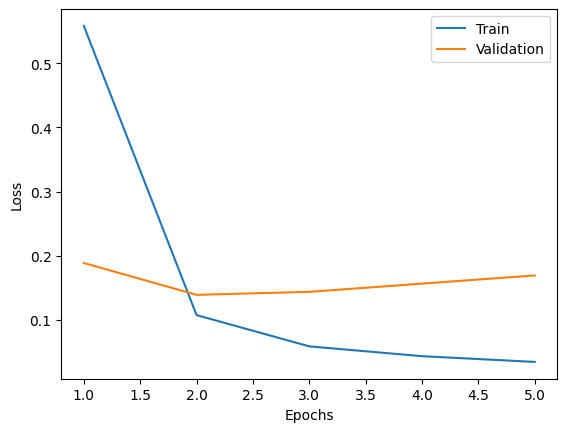

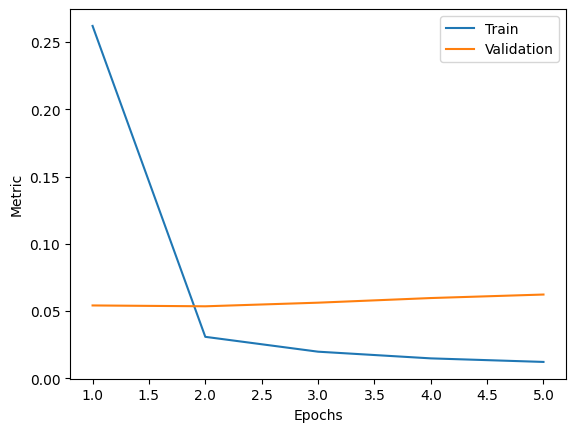

In [540]:
trainer.plot_history()

In [541]:
trainer.best_epoch

2

#Get Accuracy, Predictions

In [542]:
testset = CustomDataset(X_test, y_test)

In [543]:
test_multilabel_vocab = get_vocab(testset, min_freq=2)

In [544]:
#test_loader = get_test_loaders(testset, batch_size_=hyperparameters.BATCH_SIZE,
 #                              collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(dataset=validset,
                                           batch_size=hyperparameters.BATCH_SIZE,
                                           collate_fn=lambda batch: collate_batch_multilabel(batch, test_multilabel_vocab),
                                           shuffle=True)

In [545]:
# Get the prediction and accuracy for the test dataset

predictions_train, target_train = trainer.predict(
    train_loader, return_targets=True)
predictions_valid, target_valid = trainer.predict(
    valid_loader, return_targets=True)
predictions_test, target_test = trainer.predict(
    test_loader, return_targets=True)

In [546]:
print(target_train.shape, predictions_train.shape)
print(target_valid.shape, predictions_valid.shape)
print(target_test.shape, predictions_test.shape)

torch.Size([28456, 10]) torch.Size([28456])
torch.Size([9485, 10]) torch.Size([9485])
torch.Size([9485, 10]) torch.Size([9485])


In [547]:
train_labels = torch.unique(target_train)
valid_labels = torch.unique(target_valid)
test_labels = torch.unique(target_test)
print(train_labels, valid_labels, test_labels)

tensor([0., 1.]) tensor([0., 1.]) tensor([0., 1.])


In [548]:
import torchmetrics
#metric = torchmetrics.functional.accuracy
##metric = torchmetrics.functional.hamming_distance
###num_classes = len(train_labels)
###print(num_classes)
#len(torch.unique(torch.cat((target_train, target_valid, target_test), dim=0)))
###metric = HammingDistance(mode='multilabel', task='multilabel',num_labels=num_classes,compute_on_step=False)
#train_labels = len(torch.unique(target_train))
#valid_labels = len(torch.unique(target_valid))
#test_labels = len(torch.unique(target_test))
#num_classes = len(torch.unique(torch.cat((target_train, target_valid, target_test), dim=0)))

#print(train_labels, valid_labels, test_labels)
#acc_train = metric(predictions_train, target_train, task='multilabel', num_classes=int(num_classes))
#acc_valid = metric(predictions_valid, target_valid, task='multilabel', num_classes=int(num_classes))
#acc_test = metric(predictions_test, target_test, task='multilabel', num_classes=int(num_classes))
#predictions_train = predictions_train.view(-1, 2)
#target_train = target_train.view(-1, 2)
##num_samples = len(trainset)
###num_classes = len(train_labels)
#predictions_train = Trainer(trainset)
###predictions_train = predictions_train.view(num_samples, num_classes)

###acc_train = metric(predictions_train, target_train)
##acc_valid = metric(predictions_valid, target_valid)
##acc_test = metric(predictions_test, target_test)

In [549]:
# Print Test Accuracy
##print('Test accuracy', acc_test * 100)
##print('Train accuracy', acc_train * 100)
##print('Valid accuracy', acc_valid * 100)

In [550]:
from sklearn.metrics import accuracy_score, f1_score
#print(accuracy_score(predictions_test, target_test)*100)
#print(accuracy_score(predictions_train, target_train)*100)
#print(accuracy_score(predictions_valid, target_valid)*100)

In [551]:
#metric = torchmetrics.functional.f1_score
#f1_train = metric(predictions_train, target_train,
                #  task='multilabel', num_classes=int(10))
#f1_valid = metric(predictions_valid, target_valid,
                  #task='multilabel', num_classes=10)
#f1_test = metric(predictions_test, target_test,
               #  task='multilabel', num_classes=10)

In [552]:
# Print Test Accuracy
#print('Test f1score', f1_test * 100)
#print('Train f1score', f1_train * 100)
#print('Valid f1score', f1_valid * 100)

In [568]:
#print(f1_score(predictions_test.numpy(), target_test.numpy(), average='micro') * 100)
#print(f1_score(predictions_train.numpy(), target_train.numpy(), average='micro') * 100)
#print(f1_score(predictions_valid.numpy(), target_valid.numpy(), average='micro') * 100)
from torchmetrics.functional.classification import multilabel_f1_score, multilabel_hamming_distance
#num_classes = target_train.shape[-1]
threshold = 0.5
average='micro'
#binary_predictions_train = (predictions_train > threshold).int()
#binary_predictions_valid = (predictions_valid > threshold).int()
#binary_predictions_test = (predictions_test > threshold).int()
import torch.nn.functional as F
num_classes = target_train.shape[-1]
binary_predictions_train = F.one_hot(predictions_train, num_classes=num_classes)
print("Train binary predictions: ", binary_predictions_train.shape)
f1_score_train = multilabel_f1_score(binary_predictions_train, target_train,num_labels=num_classes, threshold=threshold, average=average)
hamming_distance_train = multilabel_hamming_distance(binary_predictions_train, target_train, num_labels=num_classes)
print("Train F1 Score: ",f1_score_train, " Train hamming distance: ", hamming_distance_train)

num_classes = target_valid.shape[-1]
binary_predictions_valid = F.one_hot(predictions_valid, num_classes=num_classes)
print("Valid binary predictions: ", binary_predictions_valid.shape)
f1_score_valid = multilabel_f1_score(binary_predictions_valid, target_valid, num_labels=num_classes, threshold=threshold, average=average)
hamming_distance_valid = multilabel_hamming_distance(binary_predictions_valid, target_valid, num_labels=num_classes)
print("Train F1 Score: ",f1_score_valid, " Train hamming distance: ", hamming_distance_valid)

num_classes = target_test.shape[-1]
binary_predictions_test = F.one_hot(predictions_test, num_classes=num_classes)
print("Valid binary predictions: ", binary_predictions_test.shape)
f1_score_test = multilabel_f1_score(binary_predictions_test, target_test, num_labels=num_classes, threshold=threshold, average=average)
hamming_distance_test = multilabel_hamming_distance(binary_predictions_test, target_test, num_labels=num_classes)
print("Train F1 Score: ",f1_score_test, " Train hamming distance: ", hamming_distance_test)

# assuming y_true and y_pred are the ground truth and predicted labels, respectively
#f1_score = multilabel_f1_score(predictions_train, target_train, num_classes=num_classes, threshold=threshold, average=average)
#hamming_distance = multilabel_hamming_distance(predictions_train, target_train, num_labels=num_labels)

Train binary predictions:  torch.Size([28456, 10])
Train F1 Score:  tensor(0.9614)  Train hamming distance:  tensor(0.0077)
Valid binary predictions:  torch.Size([9485, 10])
Train F1 Score:  tensor(0.6892)  Train hamming distance:  tensor(0.0622)
Valid binary predictions:  torch.Size([9485, 10])
Train F1 Score:  tensor(0.7153)  Train hamming distance:  tensor(0.0569)
